# Средний вектор по новостным сайтам: LENTA, RBC, RIA

In [93]:
import json
import numpy as np
from pymystem3 import Mystem
import re
from scipy import spatial

import datetime as dt
import matplotlib.dates as mdates

class News:
    def __init__(self, id, date, title, content, url, siteType):
        self.id = id
        self.date = date
        self.title = title
        self.content = content
        self.url = url
        self.siteType = siteType
    
    @classmethod
    def from_json(cls, json_str):
        json_dict = json.loads(json_str)
        return cls(**json_dict)

## Загрузка нормализованных новостей

In [2]:
news = []
with open('/data/kasandra/year/lenta.rbc.ria.news.2016.json', encoding="utf8") as f:
    for line in f:
        news.append(News.from_json(line))
                
news_sorted_by_date = sorted(news, key=lambda w: w.date)

start = list(map(lambda w: w.date, news_sorted_by_date[:1]))[0]
end = list(map(lambda w: w.date, news_sorted_by_date[-1:]))[0]

print("count news: %s" % len(news))
print("start time: %s millis" % start)
print("end time: %s millis" % end)

count news: 39497
start time: 1451599745000 millis
end time: 1483216221000 millis


## Константы

In [3]:
day_millis = 24*60*60*1000
start_day = 1451595600000
end_day = 1483217999000

## Разбивка новостей по дням

In [5]:
days_news = {}

for start_day in range(start_day, end_day, day_millis):
    end_day = start_day + day_millis
    day_news = list(filter(lambda w: w.date >= start_day and w.date < end_day, news))
    days_news[str(start_day)] = day_news

## Загрузка TF-IDF матрицы

In [7]:
def lemmatize(text):
    return text.split(" ")

In [9]:
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = joblib.load('/data/kasandra/year/lenta.rbc.ria.news.2016.pkl')

tfidf_matrix = tfidf_vectorizer.transform(map(lambda n: n.content, news))

# Вычисление среднего вектора за год

In [50]:
year_mean = np.array(tfidf_matrix.mean(axis=0))[0]

## Вычесление средних векторов по дням

In [41]:
mean_days = {}

for day, dnews in days_news.items():
    tfidf_day = tfidf_vectorizer.transform(map(lambda n: n.content, dnews))
    mean_days[day] = np.array(tfidf_day.mean(axis=0))[0]

## Вычисление косиносов по дням

In [51]:
cos_days = {}

for day, mday in mean_days.items():
    cos_days[day] = spatial.distance.cosine(year_mean, mday)

# График

In [52]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

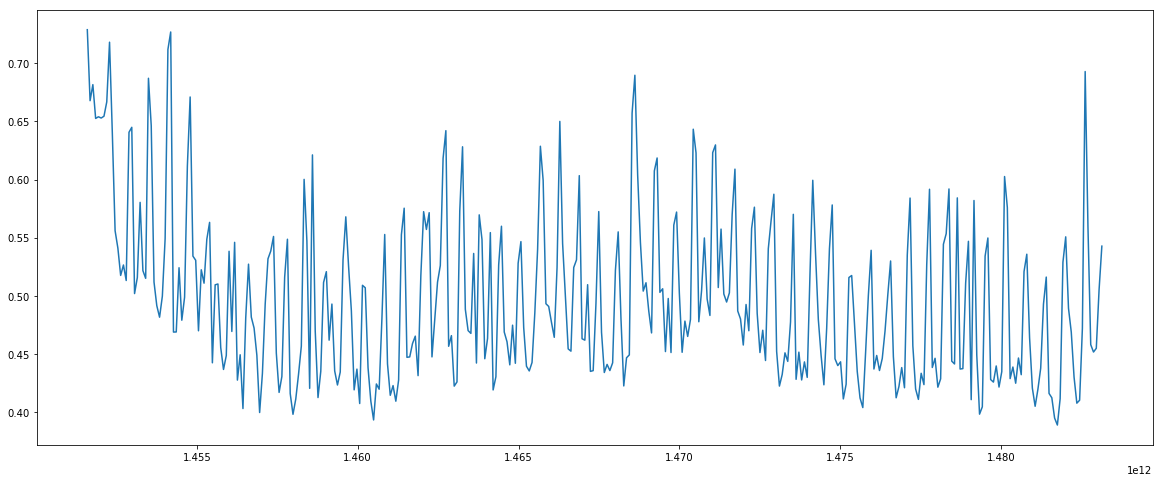

In [95]:
plt.rcParams['figure.figsize'] = (20.0, 8.0)

x = list(cos_days.keys())
y = list(cos_days.values())

plt.plot(x, y)